In [1]:
#pip install ee

In [2]:
#pip install geemap

In [3]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot
from io import StringIO


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()




In [4]:
lake = ee.FeatureCollection('projects/ee-touheda-khanom/assets/samplinglakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))


Map.addLayer(lake)
Map.centerObject(lake, 16)
Map

Map(center=[43.83093869244275, -74.84826397158908], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
Map.addLayer(station)
Map.centerObject(station, 16)


In [6]:
sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

# sentinel2_bands =['B1','B2','B3','B4']
# STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red']

In [7]:
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1': img.select('Aerosols'),
        'b2': img.select('Blue'),
        'b3': img.select('Green'),
        'b4': img.select('Red')
    }).rename("CO")
    
    bad2 = cdo.where(cdo.gte(0), 1).rename("bad2")
    co = cdo.multiply(bad2).rename("CO")
    mask = co.neq(0)

    return img.addBands(co).clip(lake).updateMask(mask)


In [8]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage


s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(lake) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES) \
    .map(cdom)


In [9]:
 first_image = s2.first()  # Get the first image from the collection
band_names = first_image.bandNames().getInfo()
print("Band Names:", band_names)

Band Names: ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'CO']


In [10]:
#How many images?
print(s2.size().getInfo())


366


In [11]:
def station_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).get('CO')
    return img.set('date', img.date().format()).set('CDOM',mean)

station_reduced_imgs = s2.map(station_mean)
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','CDOM']).values().get(0)
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])

#df
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])
pd.set_option('display.max_rows', None)

df

,date,CDOM
0,2019-05-06T16:01:11,6.929021
1,2019-05-06T16:01:08,5.421134
2,2019-05-11T16:01:12,5.596865
3,2019-05-16T16:01:11,5.569435
4,2019-05-16T16:01:08,5.466830
5,2019-05-26T16:01:10,8.000575
6,2019-05-26T16:01:07,6.946026
7,2019-05-31T16:01:16,7.930212
8,2019-05-31T16:01:12,7.629593
9,2019-06-15T16:01:11,6.766762


In [12]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,CDOM
0,2019-05-06,6.929021
1,2019-05-06,5.421134
2,2019-05-11,5.596865
3,2019-05-16,5.569435
4,2019-05-16,5.466830
5,2019-05-26,8.000575
6,2019-05-26,6.946026
7,2019-05-31,7.930212
8,2019-05-31,7.629593
9,2019-06-15,6.766762


In [13]:
# import pandas as pd

# # Filter out CDOM values greater than 20
# df = df[df['CDOM'] <= 20]


# df

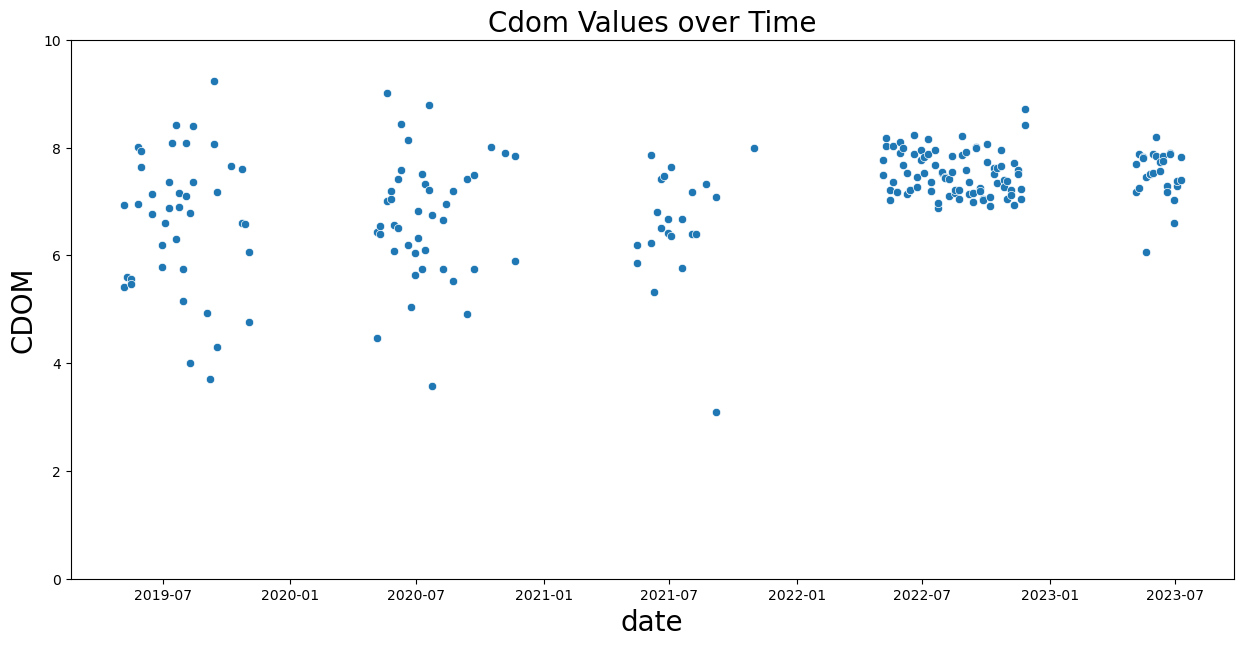

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)
ax.set_ylim(0,10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()
